# Alzheimer's Prediction 

### Variable Descriptions
* `directory.id`	Id assigned to imaging directories. Not from LONi data
* `Subject (PTID)`	Participant ID
* `RID`	Participant roster ID
* `Image.data.ID`	MRI ID
* `Modality`	Image type
* `Visit`	1=screening scan
* `Acq.Date`	MRI date
* `DX.bl`	Diagnosis at baseline
* `EXAMDATE`	Examination Date
* `AGE`	    Age at baseline
* `PTGENDER`	Sex
* `PTEDUCAT`	Years of Education
* `PTETHCAT`	Ethnicity
* `PTRACCAT`	Race
* `APOE4`	APOE4 genotype
* `MMSE`	MMSE score on cognitive test
* `imputed_genotype`	Challenge specific designation, TRUE=has imputed genotypes
* `APOE Genotype`	APOE allele 1 and allele 2 genotypes
* `Dx Codes for Submission`	The LMCI in the ADNI data is equivalent to MCI in test. This column just converts LMCI->MCI

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import joblib

In [2]:
data = pd.read_csv('data/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

### Remove NA

In [3]:
data.isnull().sum()

directory.id               0
Subject                    0
RID                        0
Image.Data.ID              0
Modality                   0
Visit                      0
Acq.Date                   0
DX.bl                      0
EXAMDATE                   0
AGE                        0
PTGENDER                   0
PTEDUCAT                   0
PTETHCAT                   0
PTRACCAT                   0
APOE4                      0
MMSE                       0
imputed_genotype           1
APOE Genotype              0
Dx Codes for Submission    0
dtype: int64

In [4]:
data = data.dropna()
data.isnull().sum().sum()

0

In [5]:
data.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,09-01-2005,AD,09-12-2005,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/05,LMCI,11-08-2005,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,09-02-2005,CN,09-07-2005,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


### Remove ID's and other features

In [6]:
X = data
Y = data['DX.bl']
del data

remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


## Exploratory Data Analysis (EDA)

In [7]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)
    
    print(X[var].value_counts())

Categorical variable distributions:


Distribution of PTRACCAT
White    583
Black     31
Asian     13
Name: PTRACCAT, dtype: int64

Distribution of APOE Genotype
3,3    275
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64

Distribution of PTETHCAT
Not Hisp/Latino    616
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64

Distribution of APOE4
0    322
1    234
2     71
Name: APOE4, dtype: int64

Distribution of PTGENDER
Male      363
Female    264
Name: PTGENDER, dtype: int64

Distribution of imputed_genotype
True     466
False    161
Name: imputed_genotype, dtype: int64


### Numerical Variable Distributions

Numerical Var Distributions:



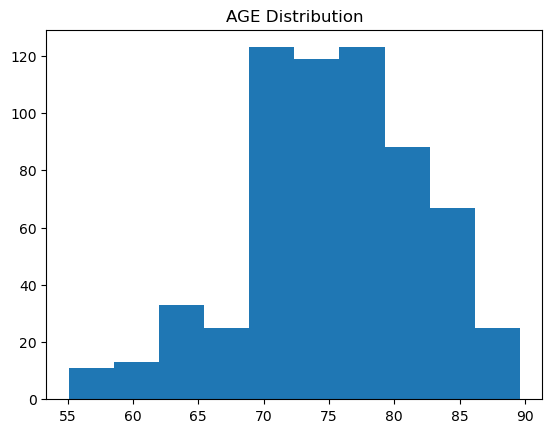

count    627.000000
mean      75.161882
std        6.689979
min       55.100000
25%       71.200000
50%       75.400000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


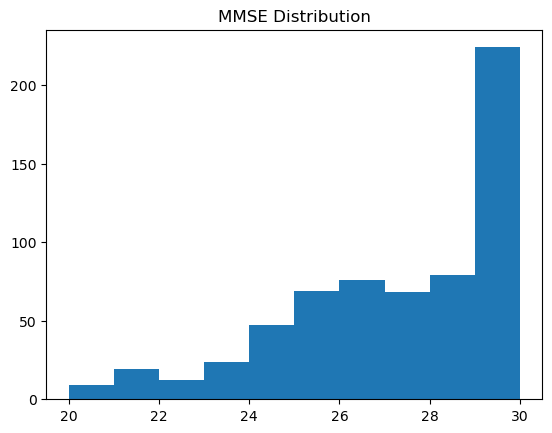

count    627.000000
mean      26.921850
std        2.563934
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


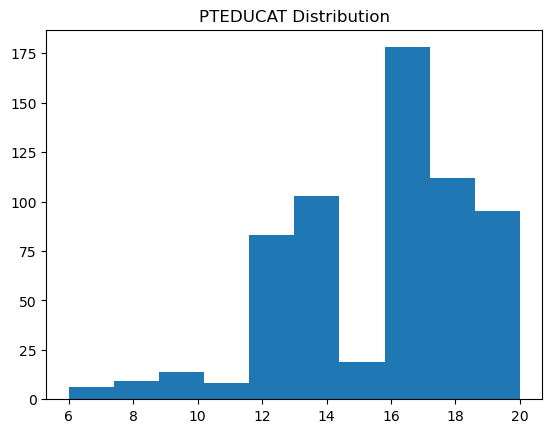

count    627.000000
mean      15.612440
std        2.978845
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Numerical Var Distributions:\n')

for var in numerical_vars:
    plt.hist(X[var], bins=10)
    plt.title(var + ' Distribution')
    plt.show()
    
    print(X[var].describe())

### Analyze target (y) distribution

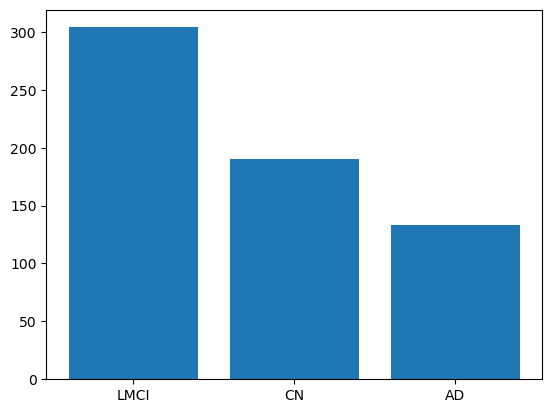

In [9]:
plt.bar(Y.value_counts().index, Y.value_counts())
plt.show()

## Pre-processing

### Convert Categorical Variables to 1-Hot

In [10]:
for var in cat_vars:
    print(f'Converting {var} to 1-hot encoding')
    one_hot_df = pd.get_dummies(X[var], prefix=var)
    X = pd.concat([X, one_hot_df], axis=1)
    X.drop(var, axis=1, inplace=True)
    
X.head(4)

Converting PTRACCAT to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting PTETHCAT to 1-hot encoding
Converting APOE4 to 1-hot encoding
Converting PTGENDER to 1-hot encoding
Converting imputed_genotype to 1-hot encoding


,AGE,PTEDUCAT,MMSE,PTRACCAT_Asian,PTRACCAT_Black,PTRACCAT_White,"APOE Genotype_2,2","APOE Genotype_2,3","APOE Genotype_2,4","APOE Genotype_3,3",...,PTETHCAT_Hisp/Latino,PTETHCAT_Not Hisp/Latino,PTETHCAT_Unknown,APOE4_0,APOE4_1,APOE4_2,PTGENDER_Female,PTGENDER_Male,imputed_genotype_False,imputed_genotype_True
0,81.3,18,20,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,1
1,67.5,10,27,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,1,0
2,73.7,16,29,0,0,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
3,80.4,13,25,0,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,1


### Normalization code

In [11]:
def normalize(X):
    X = np.array(X)
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)

    normalized_X = (X - means) / stds

    print('Normalizing:')
    for i, (mean, std) in enumerate(zip(means, stds)):
        print(f'  Variable {i+1}: Mean = {mean:.2f}, Standard Deviation = {std:.2f}')

    return normalized_X

## Train/Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

num_test = X_test.shape[0]

## Logistic Regression, Random Forest, MLP

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [14]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [15]:
log_clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000000, multi_class='multinomial')
print('Validation Accuracy = ', format(cross_val_score(log_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  69.27%


In [16]:
rf_clf = RandomForestClassifier(n_estimators=200)
print('Validation Accuracy = ', format(cross_val_score(rf_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  65.06%


In [17]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(15, 10), alpha=3, learning_rate='adaptive', max_iter=100000)
print('Validation Accuracy = ', format(cross_val_score(mlp_clf, X_train, y_train, cv=5).mean(), '.2%'))

Validation Accuracy =  50.09%


## Model Selection

### Choosing Logistic Regression
* `Validation Score = .67`

### Test Logistic Regression Model

In [18]:
log_clf.fit(X_train, y_train)

log_clf_preds = log_clf.predict(X_test)
    
log_clf_accuracy = (log_clf_preds == y_test)
print('Test Accuracy =', format( np.sum(log_clf_accuracy)/num_test, '.2%'))

Test Accuracy = 73.02%


## Saving the final model

In [19]:
joblib.dump(log_clf, 'model/alzheimer_model.pkl')

['model/alzheimer_model.pkl']